In [154]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Name : Animesh Singh
## Roll no. : 12140200

## Note that this was done in kaggle environment and would require access to input datasets to run smoothly without any errors.

In [196]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
import numpy as np
import pandas as pd
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils
import torch.optim as optim
import random

## LOADING DATASET

In [156]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_dir='/kaggle/input/extracted-faces/face_images'

In [157]:
full_dataset = datasets.ImageFolder(dataset_dir, transform=transform)

train_size = int(0.8 * len(full_dataset))  
test_size = len(full_dataset) - train_size 

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

## Function to test the model accuracy on clean dataset

In [158]:
def test_model_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")

## Importing the model trained in first phase

In [159]:
class CNN(nn.Module):
    def __init__(self, num_classes=26):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 10 * 10, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 128 * 10 * 10)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
model_path = '/kaggle/input/cnn1-minor-project-advml/cnn1.pth'
model = CNN()
model.load_state_dict(torch.load(model_path))
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=26, bias=True)
)

In [160]:
data_dir = '/kaggle/input/extracted-faces/face_images'
class_names = sorted(os.listdir(data_dir))
class_mapping = {str(i): class_name for i, class_name in enumerate(class_names)}
print(class_mapping)

{'0': 'Ada Sharma', '1': 'Aditya Sharma', '2': 'Alia Bhatt', '3': 'Amitabh Bachchan', '4': 'Amogh', '5': 'Animesh Singh', '6': 'Anumula Chaitanya Sai', '7': 'Aritra', '8': 'Arulnithi', '9': 'Aryan Kumar', '10': 'Deepika', '11': 'Dhoni', '12': 'Kishan', '13': 'Mallikarjun', '14': 'Mohit Agarwala', '15': 'Naveetha', '16': 'Prarabdh', '17': 'Rahul', '18': 'Rashmika Mandana', '19': 'Sanjib Patra', '20': 'Uplab Rajak', '21': 'Vaibhav_Arora', '22': 'Virat', '23': 'Vishesh_Thakur', '24': 'chirag', '25': 'tanmoy'}


In [161]:
model.eval()
test_model_accuracy(model, train_loader)
test_model_accuracy(model, test_loader)

Accuracy: 0.8923
Accuracy: 0.8801


## 89% accuracy on clean dataset

In [162]:
if not os.path.exists(f'/kaggle/working/training/'):
        os.makedirs(f'/kaggle/working/training/')

## Code for applying patch at random location in the image

In [163]:
def apply_patch(image, patch, patch_size):
    # Get image dimensions
    _, channels, height, width = image.size()
    
    # Choose a random position to apply the patch
    top = np.random.randint(0, height - patch_size)
    left = np.random.randint(0, width - patch_size)
    bottom = top + patch_size
    right = left + patch_size
    
    # Apply the patch to the image
    image[:, :, top:bottom, left:right] = patch
    
    return image

## Lets take a sample image from dataset and apply the patch at random location

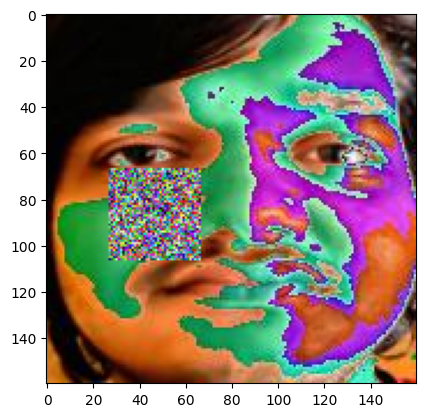

In [164]:
image = Image.open('/kaggle/input/extracted-faces/face_images/Aditya Sharma/IMG-20240119-WA0016_0.jpg').convert('RGB')
img = transforms.ToTensor()(image).unsqueeze(0)
patch_size = 40
patch = (torch.rand(3, patch_size, patch_size))
image_with_patch = apply_patch(img, patch, patch_size)
image_with_patch=image_with_patch.squeeze(0)
image_with_patch=image_with_patch.permute(1,2,0)
plt.imshow(image_with_patch)

## The function is working correctly. Note that the pink and green parts seen in this image is not actually because of the function, but because of preprocessing done while extracting faces in phase-1 which caused whole dataset to become like this.

## Function to train patch for untargeted attack. It returns a single patch capable of performing untargeted attack on entire dataset

In [165]:
def train_adversarial_patch(model, loader, num_epochs=10):
    patches=[]
    idx=0
    max_loss=-np.inf
    model.eval()
    for epoch in range(num_epochs):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            images_with_patch = apply_patch(images, adversarial_patch, patch_size)
            outputs = model(images_with_patch)
            loss = -criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
        loss=-loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}')
        if loss>max_loss:
            idx=epoch
        patches.append(adversarial_patch.clone().detach())
    return patches[idx-1]

In [166]:
patch_size = 40
lr=0.001
num_epochs=20
adversarial_patch = nn.Parameter(torch.rand(3, patch_size, patch_size))
optimizer = optim.Adam([adversarial_patch], lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
adversarial_patch.to(device)

tensor([[[0.3476, 0.4379, 0.5850,  ..., 0.1478, 0.8210, 0.8765],
         [0.6813, 0.6480, 0.9955,  ..., 0.5766, 0.8756, 0.2269],
         [0.6114, 0.8133, 0.4309,  ..., 0.2682, 0.8210, 0.1182],
         ...,
         [0.8791, 0.3606, 0.7423,  ..., 0.8899, 0.8603, 0.9726],
         [0.8881, 0.2044, 0.8718,  ..., 0.4344, 0.7100, 0.9648],
         [0.0714, 0.3578, 0.5059,  ..., 0.3141, 0.5275, 0.1237]],

        [[0.6955, 0.8380, 0.6859,  ..., 0.7807, 0.2473, 0.5296],
         [0.3181, 0.5159, 0.0246,  ..., 0.2800, 0.5359, 0.8365],
         [0.6062, 0.1170, 0.7577,  ..., 0.5143, 0.0838, 0.2103],
         ...,
         [0.7374, 0.1778, 0.7421,  ..., 0.1157, 0.6797, 0.2271],
         [0.9932, 0.9118, 0.8286,  ..., 0.8951, 0.5299, 0.7731],
         [0.4547, 0.2271, 0.9963,  ..., 0.4765, 0.5840, 0.0015]],

        [[0.2869, 0.0216, 0.4610,  ..., 0.5447, 0.3223, 0.0736],
         [0.9005, 0.8279, 0.8288,  ..., 0.9600, 0.8501, 0.0366],
         [0.1048, 0.9091, 0.1136,  ..., 0.1441, 0.1532, 0.

In [167]:
best_patch=train_adversarial_patch(model, train_loader, num_epochs)

Epoch [1/20], Loss: 0.010076014325022697
Epoch [2/20], Loss: 1.921513557434082
Epoch [3/20], Loss: 8.367020606994629
Epoch [4/20], Loss: 53.009132385253906
Epoch [5/20], Loss: 15.813955307006836
Epoch [6/20], Loss: 114.02778625488281
Epoch [7/20], Loss: 123.67947387695312
Epoch [8/20], Loss: 152.39849853515625
Epoch [9/20], Loss: 51.82686996459961
Epoch [10/20], Loss: 240.43405151367188
Epoch [11/20], Loss: 279.25946044921875
Epoch [12/20], Loss: 383.3429870605469
Epoch [13/20], Loss: 0.0
Epoch [14/20], Loss: 105.86536407470703
Epoch [15/20], Loss: 246.3959503173828
Epoch [16/20], Loss: 301.2366943359375
Epoch [17/20], Loss: 553.1309814453125
Epoch [18/20], Loss: 148.05316162109375
Epoch [19/20], Loss: 371.6993713378906
Epoch [20/20], Loss: 331.9564208984375


## Function for Testing adversarial patch

In [168]:
def test_adversarial_patch(model, loader, patch, patch_size):
    model.eval()
    misclassified = 0
    total = 0
    
    for images, labels in loader:
        images,labels=images.to(device),labels.to(device)
        images_with_patch = apply_patch(images, patch, patch_size)
        outputs = model(images_with_patch)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        misclassified += (predicted != labels).sum().item()
    
    accuracy = 1 - misclassified / total
    print("Accuracy after applying adversarial patch:", accuracy)
    print('Total images',total)
    print('Misclassified',misclassified)
    print('==================================================================')

## As we can see, the accuracy dropped from 88-89% to 4-5% after applying patch at random locations in both train and test sets

In [169]:
test_adversarial_patch(model, test_loader, best_patch, patch_size)
test_adversarial_patch(model, train_loader, best_patch, patch_size)

Accuracy after applying adversarial patch: 0.042328042328042326
Total images 567
Misclassified 543
Accuracy after applying adversarial patch: 0.05562913907284772
Total images 2265
Misclassified 2139


## To visualise an example, lets see an image before application, its prediction, the patch, the image after applying patch and its corresponding prediction

torch.Size([1, 3, 160, 160])
Initial prediction tensor([5], device='cuda:0') Prediction on modified image tensor([1], device='cuda:0')


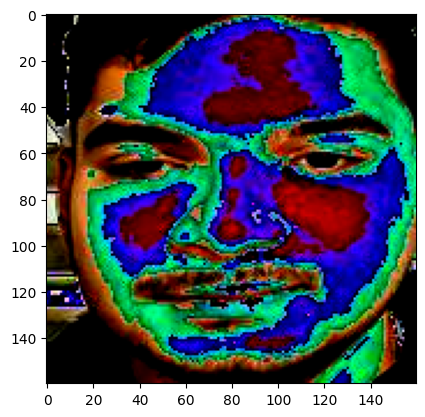

In [170]:
img_path = '/kaggle/input/extracted-faces/face_images/Animesh Singh/IMG-20240119-WA0017_0.jpg'
image = Image.open(img_path)
image = transform(image)
plt.imshow(image.permute(1,2,0))
image=image.unsqueeze(0)
print(image.shape)
image=image.to(device)
prediction=model(image)
_,p1 = torch.max(prediction,1)
patched_image=apply_patch(image, best_patch, patch_size)
outputs = model(patched_image)
_, p2 = torch.max(outputs, 1)
print('Initial prediction',p1,'Prediction on modified image',p2)

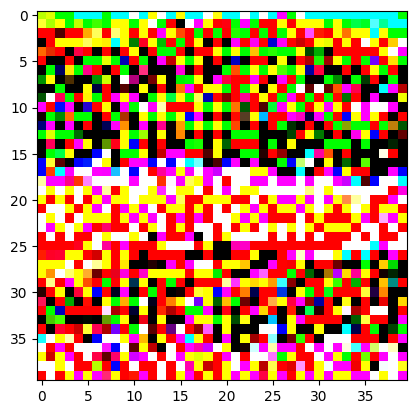

In [171]:
plt.imshow(best_patch.detach().permute(1,2,0))

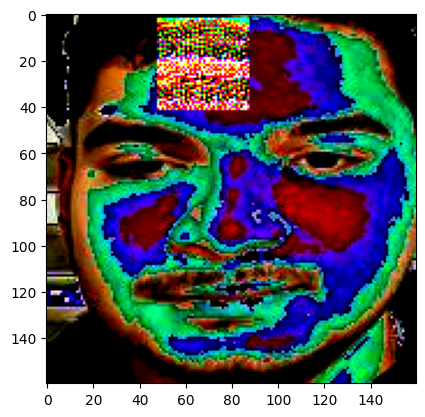

In [172]:
plt.imshow(patched_image.squeeze(0).cpu().detach().permute(1,2,0))

## Function to train adversarial patch for targeted attack. Changed the loss function. Wasn't able to get a universal adversarial patch but was able to implement it for a particular image. In a similar way, we can find patches for any image corresponding to any target class.

In [412]:
def train_adversarial_patch_target(model, image, label, target_label, num_epochs=10):
    patches = []
    idx = 0
    min_loss = np.inf
    model.eval()
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        image = image.to(device)
        images_with_patch = apply_patch(image.unsqueeze(0), target_patch, patch_size)
        outputs = model(images_with_patch)
        target_labels = torch.tensor([target_label], dtype=torch.long, device=device) 
        labels = torch.tensor([label], dtype=torch.long, device=device)
        loss = 10*criterion(outputs, target_labels) - criterion (outputs,labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        loss = loss.item()
        if epoch%20==0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}')

        if loss < min_loss:
            idx = epoch
            min_loss = loss
            
        patches.append(target_patch.clone().detach())
    
    return patches[-1]


## Function to test target patch

- correctly_classified : this means the patch attack didnt work, the model was able to classify correctly

- correctly_classified_target : this means that the image was actually of target class itself so no use of performing attack

- misclassified_target : this is our desired goal when the model misclassifies the image as the target class

- misclassified_other : this means that model misclassified the image but the prediction was not the target class

In [413]:
def test_adversarial_patch_target(model, image, label, patch, patch_size, target_label):
    model.eval()
    
    image = image.to(device)
    images_with_patch = apply_patch(image.unsqueeze(0), patch, patch_size)
    plt.imshow(images_with_patch.clone().cpu().squeeze(0).permute(1,2,0))
    outputs = model(images_with_patch)
    _, predicted = torch.max(outputs, 1)
    print(predicted,label,target_label)
    if predicted == label:
        if label!=target_label:
            return 'correctly_classified'
        else:
            return 'correctly_classified_target'
    elif predicted == target_label:
        return 'misclassified_target'
    else:
        return 'misclassified_other'

In [414]:
patch_size = 80
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

target_patch = nn.Parameter(torch.rand(3, patch_size, patch_size))
optimizer = optim.Adam([target_patch], lr=lr)
criterion = nn.CrossEntropyLoss()

model.to(device)
target_patch.to(device)

tensor([[[0.8393, 0.3894, 0.5020,  ..., 0.0716, 0.5942, 0.4819],
         [0.7106, 0.0998, 0.2574,  ..., 0.4546, 0.8422, 0.9755],
         [0.5444, 0.5116, 0.3669,  ..., 0.5025, 0.7974, 0.0260],
         ...,
         [0.8191, 0.8367, 0.6570,  ..., 0.9814, 0.8587, 0.5135],
         [0.6741, 0.0940, 0.8890,  ..., 0.4045, 0.7524, 0.3965],
         [0.4205, 0.6375, 0.4871,  ..., 0.2250, 0.0980, 0.3713]],

        [[0.0546, 0.9222, 0.8278,  ..., 0.9808, 0.0083, 0.3967],
         [0.8478, 0.6045, 0.8056,  ..., 0.4536, 0.2139, 0.2520],
         [0.1962, 0.4714, 0.2323,  ..., 0.1146, 0.9736, 0.6769],
         ...,
         [0.4455, 0.6686, 0.4998,  ..., 0.7706, 0.7069, 0.2742],
         [0.4960, 0.2795, 0.7731,  ..., 0.2657, 0.1462, 0.0813],
         [0.6962, 0.9306, 0.5230,  ..., 0.0027, 0.8310, 0.9318]],

        [[0.8253, 0.1725, 0.7244,  ..., 0.7868, 0.2317, 0.0414],
         [0.0433, 0.6048, 0.5244,  ..., 0.4760, 0.8008, 0.7982],
         [0.8490, 0.8671, 0.2469,  ..., 0.0108, 0.8877, 0.

In [422]:
lr=0.01
num_epochs=500
target=22

Epoch [1/500], Loss: 320.048583984375
Epoch [21/500], Loss: 624.05029296875
Epoch [41/500], Loss: 745.2744140625
Epoch [61/500], Loss: 433.8326416015625
Epoch [81/500], Loss: 489.319580078125
Epoch [101/500], Loss: 153.80274963378906
Epoch [121/500], Loss: 417.08404541015625
Epoch [141/500], Loss: 120.31173706054688
Epoch [161/500], Loss: -110.56800079345703
Epoch [181/500], Loss: 33.5606689453125
Epoch [201/500], Loss: 297.780029296875
Epoch [221/500], Loss: -108.4088134765625
Epoch [241/500], Loss: -102.4728012084961
Epoch [261/500], Loss: -141.2464599609375
Epoch [281/500], Loss: -112.94208526611328
Epoch [301/500], Loss: -115.46980285644531
Epoch [321/500], Loss: -90.25596618652344
Epoch [341/500], Loss: -100.94700622558594
Epoch [361/500], Loss: -196.46607971191406
Epoch [381/500], Loss: -129.7530975341797
Epoch [401/500], Loss: -132.24185180664062
Epoch [421/500], Loss: -145.1268768310547
Epoch [441/500], Loss: -75.9935073852539
Epoch [461/500], Loss: -121.82186126708984
Epoch [4

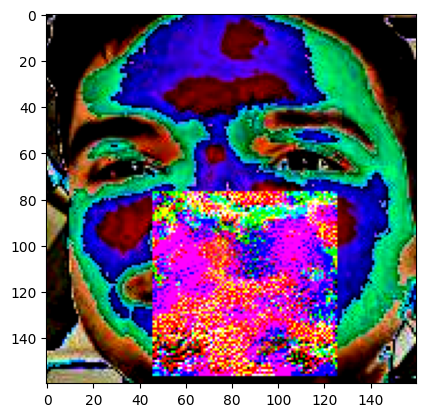

In [423]:
image_p='/kaggle/input/extracted-faces/face_images/Animesh Singh/IMG-20240119-WA0020_0.jpg'
image=Image.open(image_p)
image=transform(image)
label=5
ta_patch=train_adversarial_patch_target(model, image, label, target, num_epochs)
result = test_adversarial_patch_target(model, image, label, ta_patch, patch_size, target)
print(result)

## As we can see, the trends in loss clearly shows how the patch affected the classification of image until we reached a point where an image of original label 5 was classified as the target class 22. Hence, our targeted patch attack was successful.

## Note that the distortions other than the patch was due to preprocessing in the initial phase, I can share the dataset of extracted faces i worked with to confirm the same. Only the patch was passed to the optimizer and was updated in order to fool the model.

## This concludes the phase 2 of the minor project

## Name : Animesh Singh
## Roll no. : 12140200